<a href="https://colab.research.google.com/github/Lee-Gunju/GraphEmbedding-For-Soccer-Tactical-Formations/blob/main/football_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== 모델 수정! 
1. input 형태를 split하기 (다 나뉘기) => 데이터셋을 적용하는게 문제!, 정 안되면 각 인풋형태를 수동으로 만들어 적용하는 수밖에 없음! 
2. categorical features(string)는 embedding layer 추가하기! 
3. residual blocks 추가하기! 




In [175]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt



In [176]:
dataframe = pd.read_excel('Data.xlsx',  sheet_name = ['20-21-test','19-20', '18-19', '17-18', '16-17', '15-16', '14-15', '13-14', '12-13', '11-12', '10-11'])
dataframe = pd.concat(dataframe, axis= 0, ignore_index=True)

In [177]:
dataframe.columns

Index(['match_oder', 'oppense_team', 'FW0', 'FW0B', 'FW1', 'AMF0', 'AMF0B',
       'AMF1', 'AMF1B', 'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B',
       'CMF0C', 'CMF1', 'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1',
       'WB1B', 'CB0', 'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Formation',
       'Opp_Level', 'Season', 'Ball_pos', 'Win', 'Style', 'sum'],
      dtype='object')

In [178]:
CSV_HEADER = ["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Opp_Level', 'Season','Ball_pos','match_oder', 'oppense_team', 'Formation', 'Win', 'Style','sum']


CATEGORICAL_DATA = ['match_oder', 'oppense_team','Opp_Level', 'Season' ]


CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted([str(value) for value in list(dataframe[feature_name].unique())])
    for feature_name in CSV_HEADER
    if feature_name
    in list(CATEGORICAL_DATA)
}

NUMERIC_FEATURE_NAMES = ['Ball_pos']
BINARY_FEATURE_NAMES = ["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1']



FEATURE_NAMES = NUMERIC_FEATURE_NAMES + BINARY_FEATURE_NAMES + list(
    CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)

In [179]:
dataframe_formation = dataframe['Formation'].unique().tolist()
dataframe_formation_to_encoded = {x: i for i, x in enumerate(dataframe_formation)}
dataframe_index_to_formation = {i: x for i, x in enumerate(dataframe_formation)}
dataframe['Formation'] = dataframe['Formation'].map(dataframe_formation_to_encoded)



win_cate = dataframe['Win'].unique().tolist()
win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 
dataframe['Win'] = dataframe['Win'].map(win_to_encoded)


In [180]:
dataframe.dtypes

match_oder       object
oppense_team     object
FW0               int64
FW0B              int64
FW1               int64
AMF0              int64
AMF0B             int64
AMF1              int64
AMF1B             int64
Wing0             int64
Wing0B            int64
Wing1             int64
Wing1B            int64
CMF0              int64
CMF0B             int64
CMF0C             int64
CMF1              int64
CMF1B             int64
DMF0              int64
DMF1              int64
DMF1B             int64
WB0               int64
WB0B              int64
WB1               int64
WB1B              int64
CB0               int64
CB0B              int64
CB1               int64
CB1B              int64
GK0               int64
GK1               int64
Formation         int64
Opp_Level        object
Season           object
Ball_pos        float64
Win               int64
Style             int64
sum               int64
dtype: object

In [213]:
dataframe = dataframe.sample(frac=1, random_state=42)
dataframe

# 10-11 ~ 19-20 시즌 - train
train_dt = dataframe[dataframe['Season'] != '2020-2021']

# 20-21 시즌 - test
test_dt = dataframe[dataframe['Season'] == '2020-2021']

In [214]:
train_data = train_dt[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].values.astype(np.float)

train_data_cate = train_dt[['Opp_Level', 'Season','match_oder', 'oppense_team']].values


test_data = test_dt[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'Ball_pos']].values.astype(np.float)

test_data_cate = test_dt[['Opp_Level', 'Season','match_oder', 'oppense_team']].values


y_formation = train_dt["Formation"].values
y_style = train_dt['Style'].values
y_win = train_dt['Win'].values


y_test_formation = test_dt["Formation"].values
y_test_style = test_dt['Style'].values
y_test_win = test_dt['Win'].values

In [215]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES + BINARY_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [216]:
def encode_inputs(inputs, encoding_size):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = index(inputs[feature_name])
            # Create an embedding layer with the specified dimensions
            embedding_ecoder = layers.Embedding(
                input_dim=len(vocabulary), output_dim=encoding_size
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding_ecoder(value_index)
        elif feature_name in NUMERIC_FEATURE_NAMES:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)

        else:
            # Project the numeric feature to encoding_size using linear transformation.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

In [217]:
def create_model(encoding_size):
  inputs = create_model_inputs()
  feature_list = encode_inputs(inputs, encoding_size)
  concat = layers.concatenate(feature_list)

  x_1_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_1 = layers.BatchNormalization()(x_1_input)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_1) + x_1_input
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_2 = layers.BatchNormalization()(x_2_input)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_2) + x_2_input
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3_input = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_3 = layers.BatchNormalization()(x_3_input)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(x_3) + x_3_input
  x_3 = layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001))(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.ReLU()(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)

  model = keras.Model(inputs=inputs, outputs = [output_for, output_style, output_win])
  return model


In [218]:
learning_rate = 0.01
dropout_rate = 0.20
num_epochs = 100
encoding_size = 16

In [219]:
model = create_model(encoding_size=encoding_size) 

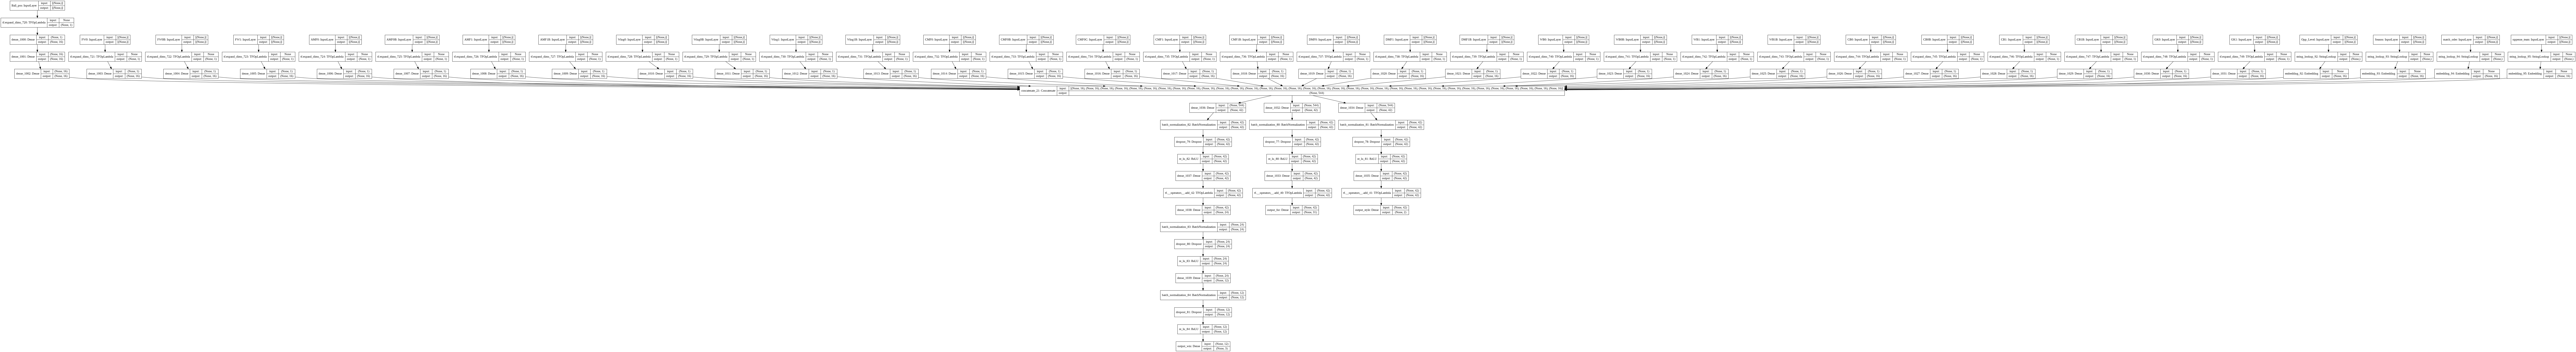

In [220]:
keras.utils.plot_model(model, show_shapes=True)

In [221]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy()],
                      'output_win':[keras.metrics.SparseCategoricalAccuracy()], 
                      'output_style':[keras.metrics.SparseCategoricalAccuracy()] }
              
              # {'output_for': [keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')],
              #         'output_win':[keras.losses.SparseCategoricalCrossentropy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')], 
              #         'output_style':[keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]}
)

In [222]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 15, restore_best_weights=True)

In [223]:
history = model.fit(x={
    'FW0': train_data[:, 0:1],
    'FW0B':train_data[:, 1:2],
    "FW1" :train_data[:, 2:3],
    'AMF0':train_data[:, 3:4],
    'AMF0B':train_data[:, 4:5],
    'AMF1':train_data[:, 5:6],
    'AMF1B':train_data[:, 6:7],
    'Wing0':train_data[:, 7:8],
    'Wing0B':train_data[:, 8:9],
    'Wing1':train_data[:, 9:10],
    'Wing1B':train_data[:, 10:11],
    'CMF0':train_data[:, 11:12],
    'CMF0B':train_data[:, 12:13],
    'CMF0C':train_data[:, 13:14],
    'CMF1':train_data[:, 14:15],
    'CMF1B':train_data[:, 15:16],
    'DMF0':train_data[:, 16:17],
    'DMF1':train_data[:, 17:18],
    'DMF1B':train_data[:, 18:19],
    'WB0':train_data[:, 19:20],
    'WB0B':train_data[:, 20:21],
    'WB1':train_data[:, 21:22],
    'WB1B':train_data[:, 22:23],
    'CB0':train_data[:, 23:24],
    'CB0B':train_data[:, 24:25],
    'CB1':train_data[:, 25:26],
    'CB1B':train_data[:, 26:27],
    'GK0':train_data[:, 27:28],
    'GK1':train_data[:, 28:29],
    'Ball_pos':train_data[:, 29:30],

    'Opp_Level':train_data_cate[:, 0:1],
    'Season':train_data_cate[:, 1:2],
    'match_oder':train_data_cate[:, 2:3],
    'oppense_team':train_data_cate[:, 3:4],
    }, 
    y = {'output_for': y_formation, 
         'output_style': y_style,
         'output_win':y_win}, 
         epochs=num_epochs, 
         validation_split=0.1 , 
         callbacks=[early_stop])

Epoch 1/100
10/10 [==============================] - 5s 153ms/step - loss: 9.4031 - output_for_loss: 4.3349 - output_style_loss: 3.4016 - output_win_loss: 1.2726 - output_for_sparse_categorical_accuracy: 0.3651 - output_style_sparse_categorical_accuracy: 0.6217 - output_win_sparse_categorical_accuracy: 0.3882 - val_loss: 6.1453 - val_output_for_loss: 3.8391 - val_output_style_loss: 0.4448 - val_output_win_loss: 1.4408 - val_output_for_sparse_categorical_accuracy: 0.3289 - val_output_style_sparse_categorical_accuracy: 0.8158 - val_output_win_sparse_categorical_accuracy: 0.5395
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 3.8103 - output_for_loss: 1.8293 - output_style_loss: 0.4744 - output_win_loss: 1.0652 - output_for_sparse_categorical_accuracy: 0.5954 - output_style_sparse_categorical_accuracy: 0.8158 - output_win_sparse_categorical_accuracy: 0.4967 - val_loss: 5.3022 - val_output_for_loss: 2.0453 - val_output_style_loss: 1.2546 - val_output_win_loss: 1.5

In [224]:
model.evaluate(x={
    'FW0': test_data[:, 0:1],
    'FW0B':test_data[:, 1:2],
    "FW1" :test_data[:, 2:3],
    'AMF0':test_data[:, 3:4],
    'AMF0B':test_data[:, 4:5],
    'AMF1':test_data[:, 5:6],
    'AMF1B':test_data[:, 6:7],
    'Wing0':test_data[:, 7:8],
    'Wing0B':test_data[:, 8:9],
    'Wing1':test_data[:, 9:10],
    'Wing1B':test_data[:, 10:11],
    'CMF0':test_data[:, 11:12],
    'CMF0B':test_data[:, 12:13],
    'CMF0C':test_data[:, 13:14],
    'CMF1':test_data[:, 14:15],
    'CMF1B':test_data[:, 15:16],
    'DMF0':test_data[:, 16:17],
    'DMF1':test_data[:, 17:18],
    'DMF1B':test_data[:, 18:19],
    'WB0':test_data[:, 19:20],
    'WB0B':test_data[:, 20:21],
    'WB1':test_data[:, 21:22],
    'WB1B':test_data[:, 22:23],
    'CB0':test_data[:, 23:24],
    'CB0B':test_data[:, 24:25],
    'CB1':test_data[:, 25:26],
    'CB1B':test_data[:, 26:27],
    'GK0':test_data[:, 27:28],
    'GK1':test_data[:, 28:29],
    'Ball_pos':test_data[:, 29:30],

    'Opp_Level':test_data_cate[:, 0:1],
    'Season':test_data_cate[:, 1:2],
    'match_oder':test_data_cate[:, 2:3],
    'oppense_team':test_data_cate[:, 3:4],
    }, 
    y = {'output_for': y_test_formation, 
         'output_style': y_test_style,
         'output_win':y_test_win})

2/2 [==============================] - 0s 9ms/step - loss: 2.8394 - output_for_loss: 0.1145 - output_style_loss: 0.1172 - output_win_loss: 2.2343 - output_for_sparse_categorical_accuracy: 0.9737 - output_style_sparse_categorical_accuracy: 0.9211 - output_win_sparse_categorical_accuracy: 0.4474


[2.8394289016723633,
 0.11450543999671936,
 0.11717826128005981,
 2.234294891357422,
 0.9736841917037964,
 0.9210526347160339,
 0.44736841320991516]